# *Monod* fit to neural cell subtypes

In the current notebook, we run the *Monod* inference pipeline on glutamatergic subtypes in a pre-clustered mouse brain cell dataset to characterize its noise components.

## Metadata and prerequisites

Define the dataset metadata and disk locations.

In [1]:
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')

In [2]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis


In [3]:
dataset_meta = ['B08']
# 
subcluster_names = ['L2/3 IT','L5 IT','L6 IT','L5/6 NP', 'L6 CT', 'L6b']
subcluster_names = [x.replace(' ','').replace('/','') for x in subcluster_names]
cluster_names = ['Glutamatergic']
dataset_names = ['allen_'+dataset_meta[0]+'_'+y  for y in subcluster_names] \
              + ['allen_'+x+'_'+y for x in dataset_meta for y in cluster_names]  
raw_data_locations = [dataset_meta[0] for y in subcluster_names] + [x for x in dataset_meta for y in cluster_names]
transcriptome_filepath = '../polyA_ref/gg_200524_mouse_genome_polyA_cum_1'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

loom_filepaths = ['/home/ggorin/count_data/loom_allen_kb/allen_'+x+'_raw.loom' for x in raw_data_locations] 
n_datasets = len(loom_filepaths)


In [4]:
raw_data_locations

['B08', 'B08', 'B08', 'B08', 'B08', 'B08', 'B08']

In [5]:
subcluster_names

['L23IT', 'L5IT', 'L6IT', 'L56NP', 'L6CT', 'L6b']

In [6]:
dataset_names

['allen_B08_L23IT',
 'allen_B08_L5IT',
 'allen_B08_L6IT',
 'allen_B08_L56NP',
 'allen_B08_L6CT',
 'allen_B08_L6b',
 'allen_B08_Glutamatergic']

## Filtering

In [7]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy

In [8]:
allen_membership = pd.read_csv('~/count_data/allen_metadata/sc/cluster.membership.csv',skiprows = 1, names=['barcode','cluster_id'])
allen_annot = pd.read_csv('~/count_data/allen_metadata/sc/cluster.annotation.csv')
allen_membership['cell_barcode'] = allen_membership['barcode'].str[:16]
allen_membership['sample'] = allen_membership['barcode'].str[-3:]
allen_membership['cluster_id'] = allen_membership['cluster_id'].astype("category")
allen_annot.set_index('cluster_id',inplace=True)
allen_annot_bc = allen_annot.loc[allen_membership['cluster_id']][['cluster_label','subclass_label','class_label']].set_index(allen_membership.index)
meta = pd.concat((allen_membership,allen_annot_bc),axis=1)
omitted_subtypes = ('L6 IT Car3','L5 ET')

Dataset B08. 
	10975 barcodes in loom, 9216 pass filter. 8424 in annotations; of these, 8424 in loom and 7808 in filtered loom.
	L23IT: 823 cells in annotations. 823 in loom. 823 pass filter.
	L5IT: 2395 cells in annotations. 2395 in loom. 2382 pass filter.
	L6IT: 489 cells in annotations. 489 in loom. 489 pass filter.
	L56NP: 251 cells in annotations. 251 in loom. 250 pass filter.
	L6CT: 1333 cells in annotations. 1333 in loom. 1333 pass filter.
	L6b: 66 cells in annotations. 66 in loom. 66 pass filter.
	Omitted -- L6 IT Car3: 3 cells in annotations. 3 in loom. 3 pass filter.
	Omitted -- L5 ET: 9 cells in annotations. 9 in loom. 9 pass filter.
	Glutamatergic: 5357 cells in annotations. 5357 in loom. 5343 pass filter.


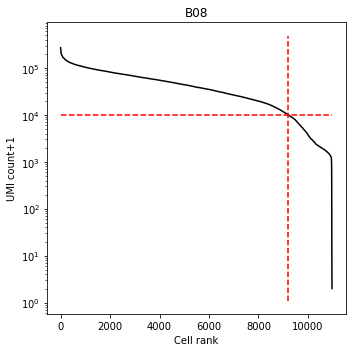

In [14]:
cf = []
thr_lb = [1e4]*4

fig1,ax1 = plt.subplots(1,1,figsize=(5,5))

for k in range(len(dataset_meta)):
    filename = loom_filepaths[len(cluster_names)*k + len(subcluster_names)]
    dataset_name = raw_data_locations[len(cluster_names)*k + len(subcluster_names)]
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1,viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k])
        
        n_annot_bcs = (meta['sample']==dataset_name).sum()
        annot_bcs_in_loom = meta[(meta['sample']==dataset_name)]['cell_barcode'].isin(bcs).sum()
        annot_bcs_in_filt_loom = meta[(meta['sample']==dataset_name)]['cell_barcode'].isin(bcs[cf_]).sum()
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')
        if k==0:
            for subcluster in subcluster_names:
                annot_bcs = meta[(meta['sample']==dataset_name) \
                                           & (meta['subclass_label'].str.replace(' ','').str.replace('/','')==subcluster) \
                                           & ~(meta['subclass_label'].isin(omitted_subtypes))]['cell_barcode']
                cf.append(np.isin(bcs,annot_bcs) & cf_)
                print(f'\t{subcluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')
                
            for subcluster in omitted_subtypes:
                annot_bcs = meta[(meta['sample']==dataset_name) \
                                           & (meta['subclass_label']==subcluster) ]['cell_barcode']
                CF_ = np.isin(bcs,annot_bcs) & cf_
                print(f'\tOmitted -- {subcluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {CF_.sum()} pass filter.')
        
        for cluster in cluster_names:
            annot_bcs = meta[(meta['sample']==dataset_name) \
                                       & (meta['class_label']==cluster) \
                                       & ~(meta['subclass_label'].isin(omitted_subtypes))]['cell_barcode']
            cf.append(np.isin(bcs,annot_bcs) & cf_)
            print(f'\t{cluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')
    ax1.set_title(dataset_name)
fig_dir = './figs/'
fig_string = fig_dir + 'kneeplots_allen_B08.png'
fig1.tight_layout()
plt.savefig(fig_string,dpi=450)

In [20]:
[x.sum() for x in cf]

[823, 2382, 489, 250, 1333, 66, 5343]

In [22]:
sum([x.sum() for x in cf[:-1]])

5343

## Preprocessing

Construct a batch by finding 3,000 genes which have at least moderate expression across most datasets. Visualize the set of genes (purple) that meet the expression filtering criteria in each dataset.

In [23]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)


INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_230328_026_allen_celltypes_1 created.
INFO:root:Dataset: allen_B08_L23IT
INFO:root:823 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:6511 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L23IT created.
INFO:root:Dataset: allen_B08_L5IT
INFO:root:2382 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:7012 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L5IT created.
INFO:root:Dataset: allen_B08_L6IT
INFO:root:489 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:5790 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L6IT created.
INFO:root:D

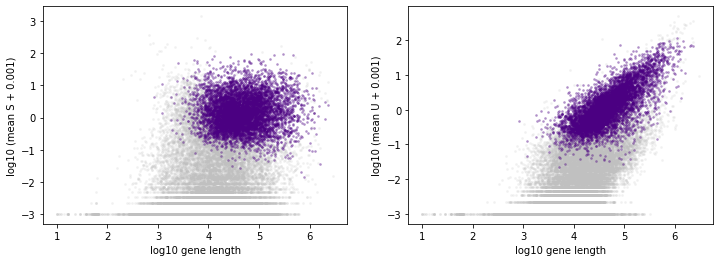

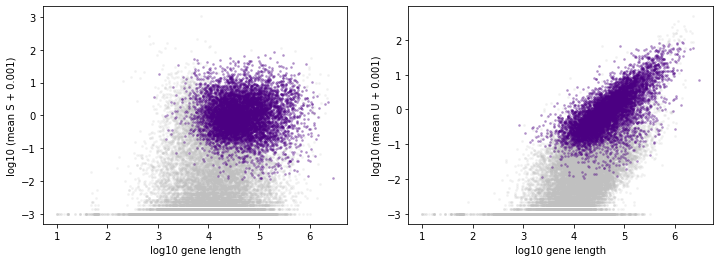

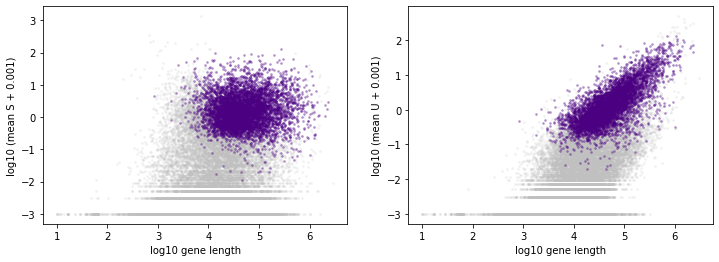

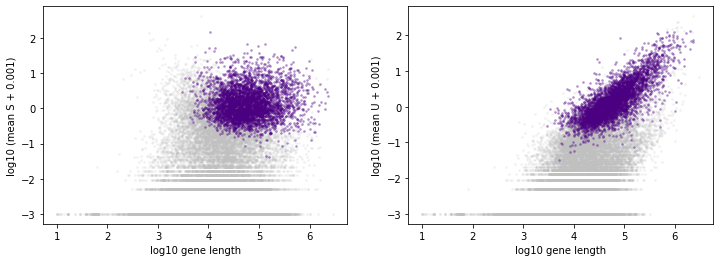

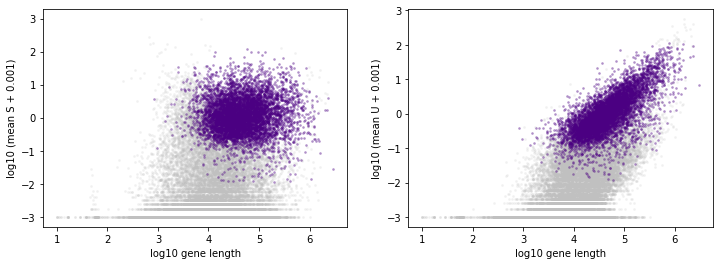

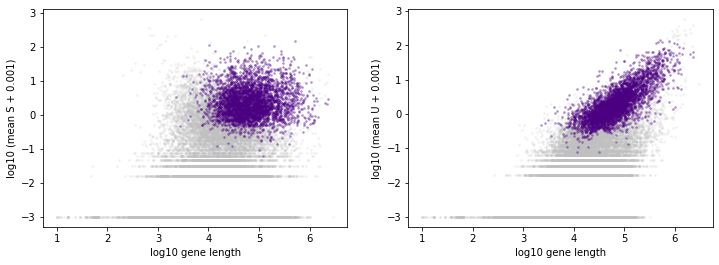

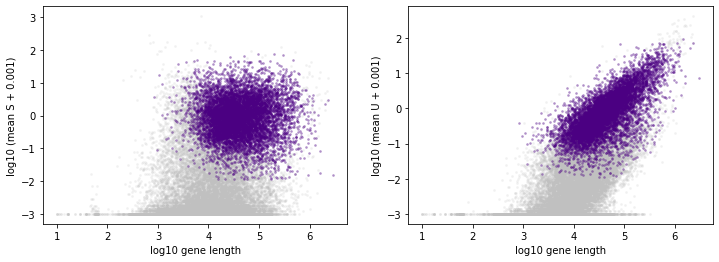

In [24]:
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='allen_celltypes',batch_id=1,\
                                             n_genes=5000,exp_filter_threshold=1,cf=cf)

## Inference

Define parameter bounds, then iterate over datasets and perform the fits.

INFO:root:Directory ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L23IT/Bursty_Poisson_20x21 created.
INFO:root:Global inference parameters stored to ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L23IT/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_B08_L23IT
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_230328_026_allen_celltypes_1/genes.csv.
INFO:root:Directory ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L23IT/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L23IT/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [1:04:31<00:00,  9.22s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L23IT/Bursty_Poisson_20x21/analysis_figures created.
INFO:root:Runtime: 3874.9 seconds.
INFO:root:Directory ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L5IT/Bursty_Poisson_20x21 created.
INFO:root:Global inference parameters stored to ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L5IT/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_B08_L5IT
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_230328_026_allen_celltypes_1/genes.csv.
INFO:root:Directory ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L5IT/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L5IT/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [1:43:44<00:00, 14.82s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L5IT/Bursty_Poisson_20x21/analysis_figures created.
INFO:root:Runtime: 6227.2 seconds.
INFO:root:Directory ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L6IT/Bursty_Poisson_20x21 created.
INFO:root:Global inference parameters stored to ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L6IT/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_B08_L6IT
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_230328_026_allen_celltypes_1/genes.csv.
INFO:root:Directory ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L6IT/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L6IT/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [1:02:02<00:00,  8.86s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L6IT/Bursty_Poisson_20x21/analysis_figures created.
INFO:root:Runtime: 3725.8 seconds.
INFO:root:Directory ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L56NP/Bursty_Poisson_20x21 created.
INFO:root:Global inference parameters stored to ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L56NP/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_B08_L56NP
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_230328_026_allen_celltypes_1/genes.csv.
INFO:root:Directory ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L56NP/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L56NP/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [32:47<00:00,  4.69s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L56NP/Bursty_Poisson_20x21/analysis_figures created.
INFO:root:Runtime: 1970.7 seconds.
INFO:root:Directory ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L6CT/Bursty_Poisson_20x21 created.
INFO:root:Global inference parameters stored to ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L6CT/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_B08_L6CT
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_230328_026_allen_celltypes_1/genes.csv.
INFO:root:Directory ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L6CT/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L6CT/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [1:11:37<00:00, 10.23s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L6CT/Bursty_Poisson_20x21/analysis_figures created.
INFO:root:Runtime: 4300.6 seconds.
INFO:root:Directory ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L6b/Bursty_Poisson_20x21 created.
INFO:root:Global inference parameters stored to ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L6b/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_B08_L6b
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_230328_026_allen_celltypes_1/genes.csv.
INFO:root:Directory ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L6b/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L6b/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [48:48<00:00,  6.97s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L6b/Bursty_Poisson_20x21/analysis_figures created.
INFO:root:Runtime: 2931.1 seconds.
INFO:root:Directory ./fits/gg_230328_026_allen_celltypes_1/allen_B08_Glutamatergic/Bursty_Poisson_20x21 created.
INFO:root:Global inference parameters stored to ./fits/gg_230328_026_allen_celltypes_1/allen_B08_Glutamatergic/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_B08_Glutamatergic
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_230328_026_allen_celltypes_1/genes.csv.
INFO:root:Directory ./fits/gg_230328_026_allen_celltypes_1/allen_B08_Glutamatergic/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230328_026_allen_celltypes_1/allen_B08_Glutamatergic/raw.sd.
INFO:root:Starting paralleli

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [2:40:04<00:00, 22.87s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230328_026_allen_celltypes_1/allen_B08_Glutamatergic/Bursty_Poisson_20x21/analysis_figures created.
INFO:root:Runtime: 9608.3 seconds.


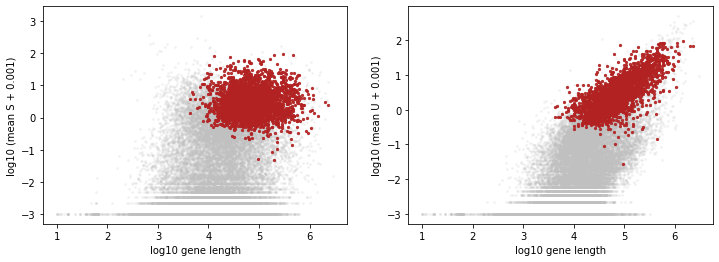

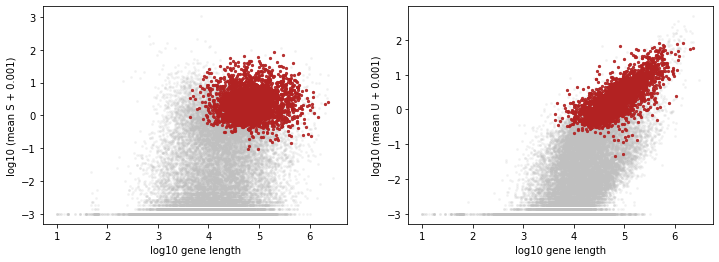

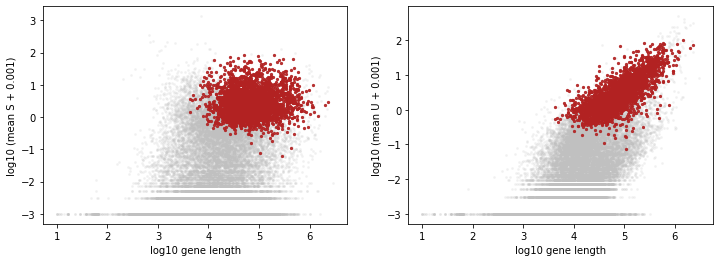

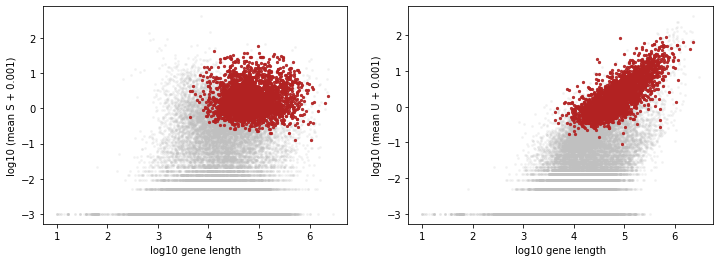

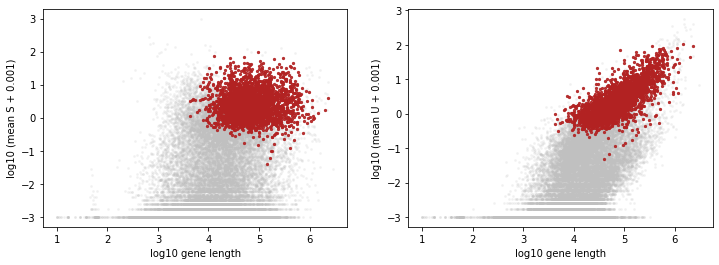

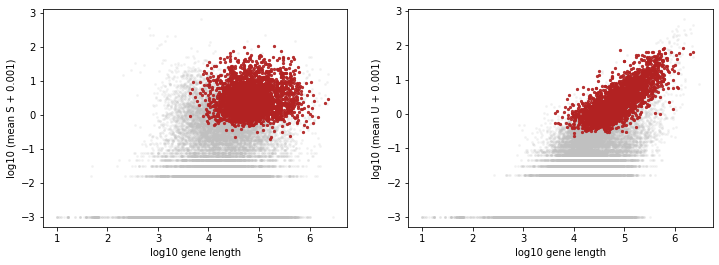

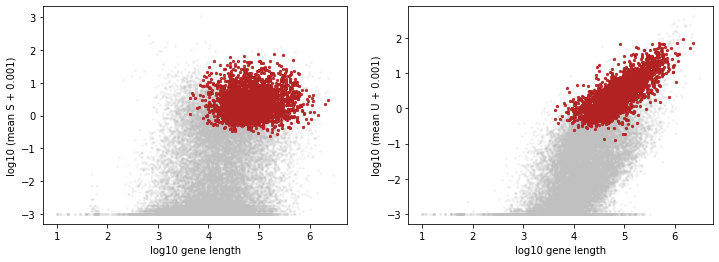

In [25]:
phys_lb = [-1.0, -1.8, -1.8 ]
phys_ub = [4.2, 2.5, 3.5]
samp_lb = [-7.5, -2]
samp_ub = [-5.5, 0]
gridsize = [20,21]



result_strings = []
for i in range(n_datasets):
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':15,'init_pattern':'moments','num_restarts':1})
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])
    full_result_string = inference_parameters.fit_all_grid_points(60,search_data)
    result_strings.append(full_result_string)

In [26]:
result_strings

['./fits/gg_230328_026_allen_celltypes_1/allen_B08_L23IT/Bursty_Poisson_20x21/grid_scan_results.res',
 './fits/gg_230328_026_allen_celltypes_1/allen_B08_L5IT/Bursty_Poisson_20x21/grid_scan_results.res',
 './fits/gg_230328_026_allen_celltypes_1/allen_B08_L6IT/Bursty_Poisson_20x21/grid_scan_results.res',
 './fits/gg_230328_026_allen_celltypes_1/allen_B08_L56NP/Bursty_Poisson_20x21/grid_scan_results.res',
 './fits/gg_230328_026_allen_celltypes_1/allen_B08_L6CT/Bursty_Poisson_20x21/grid_scan_results.res',
 './fits/gg_230328_026_allen_celltypes_1/allen_B08_L6b/Bursty_Poisson_20x21/grid_scan_results.res',
 './fits/gg_230328_026_allen_celltypes_1/allen_B08_Glutamatergic/Bursty_Poisson_20x21/grid_scan_results.res']

In [27]:
dir_string

'./fits/gg_230328_026_allen_celltypes_1'

In [28]:
dataset_strings

['./fits/gg_230328_026_allen_celltypes_1/allen_B08_L23IT',
 './fits/gg_230328_026_allen_celltypes_1/allen_B08_L5IT',
 './fits/gg_230328_026_allen_celltypes_1/allen_B08_L6IT',
 './fits/gg_230328_026_allen_celltypes_1/allen_B08_L56NP',
 './fits/gg_230328_026_allen_celltypes_1/allen_B08_L6CT',
 './fits/gg_230328_026_allen_celltypes_1/allen_B08_L6b',
 './fits/gg_230328_026_allen_celltypes_1/allen_B08_Glutamatergic']

Perform basic QC.

* Find the optimum in sampling parameters; visualize it to ensure it makes sense.
* Plot some sample transcript count distributions for 25 genes to ensure the fits look reasonable.
* Perform a chi-squared test to filter out genes with poor fit performance.
* Check sampling parameter optimum stability under gene subsampling.
* Check optimum stability after removing rejected genes.
* Compute standard errors for MLEs.
* Plot the length dependence and standard errors for gene-specific parameters.
* Plot the distribution of parameters.
* Store the updated object to disk.

INFO:root:Grid scan results loaded from ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L23IT/Bursty_Poisson_20x21/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L23IT/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L23IT/Bursty_Poisson_20x21/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L23IT/Bursty_Poisson_20x21/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 999 genes out of 2951. Runtime: 14.9 seconds.
INFO:root:Figure stored to ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L23IT/Bursty_Poisson_20x21/analysis_figures/subsampling.png.
INFO:root:Figure stored to ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L23IT/Bursty_Poisson_20x21/analysis_figures/subsampling_stability.png.
INFO:root:Original optimum: -6.24, -1.00.
INFO:

/home/ggorin/projects/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L23IT/Bursty_Poisson_20x21/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L23IT/Bursty_Poisson_20x21/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_230328_026_allen_celltypes_1/analysis_figures created.
INFO:root:Grid scan results loaded from ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L5IT/Bursty_Poisson_20x21/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L5IT/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L5IT/Bursty_Poisson_20x21/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L5IT/Bursty_Poisson_20x21/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 597 gene

/home/ggorin/projects/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L5IT/Bursty_Poisson_20x21/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L5IT/Bursty_Poisson_20x21/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_230328_026_allen_celltypes_1/analysis_figures already exists.
INFO:root:Grid scan results loaded from ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L6IT/Bursty_Poisson_20x21/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L6IT/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L6IT/Bursty_Poisson_20x21/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L6IT/Bursty_Poisson_20x21/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 792

/home/ggorin/projects/monod/src/monod/inference.py:1003: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig1, ax1 = plt.subplots(nrows=1, ncols=num_params, figsize=figsize)


INFO:root:Figure stored to ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L6IT/Bursty_Poisson_20x21/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_230328_026_allen_celltypes_1/analysis_figures already exists.
INFO:root:Grid scan results loaded from ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L56NP/Bursty_Poisson_20x21/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L56NP/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L56NP/Bursty_Poisson_20x21/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L56NP/Bursty_Poisson_20x21/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 482 genes out of 2951. Runtime: 6.0 seconds.
INFO:root:Figure stored to ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L56NP/Bursty_Poisson

/home/ggorin/projects/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L6CT/Bursty_Poisson_20x21/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L6CT/Bursty_Poisson_20x21/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_230328_026_allen_celltypes_1/analysis_figures already exists.
INFO:root:Grid scan results loaded from ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L6b/Bursty_Poisson_20x21/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L6b/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L6b/Bursty_Poisson_20x21/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L6b/Bursty_Poisson_20x21/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 364 gen

/home/ggorin/projects/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L6b/Bursty_Poisson_20x21/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_230328_026_allen_celltypes_1/allen_B08_L6b/Bursty_Poisson_20x21/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_230328_026_allen_celltypes_1/analysis_figures already exists.
INFO:root:Grid scan results loaded from ./fits/gg_230328_026_allen_celltypes_1/allen_B08_Glutamatergic/Bursty_Poisson_20x21/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_230328_026_allen_celltypes_1/allen_B08_Glutamatergic/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_230328_026_allen_celltypes_1/allen_B08_Glutamatergic/Bursty_Poisson_20x21/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_230328_026_allen_celltypes_1/allen_B08_Glutamatergic/Bursty_Poisson_20x21/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square 

/home/ggorin/projects/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/gg_230328_026_allen_celltypes_1/allen_B08_Glutamatergic/Bursty_Poisson_20x21/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_230328_026_allen_celltypes_1/allen_B08_Glutamatergic/Bursty_Poisson_20x21/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_230328_026_allen_celltypes_1/analysis_figures already exists.


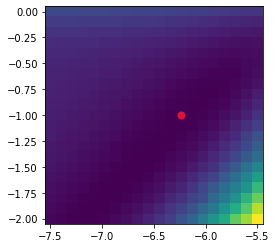

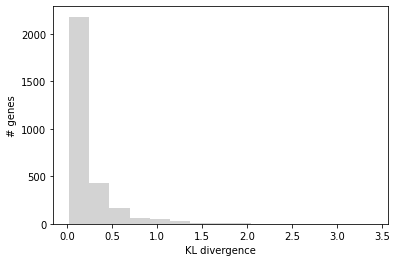

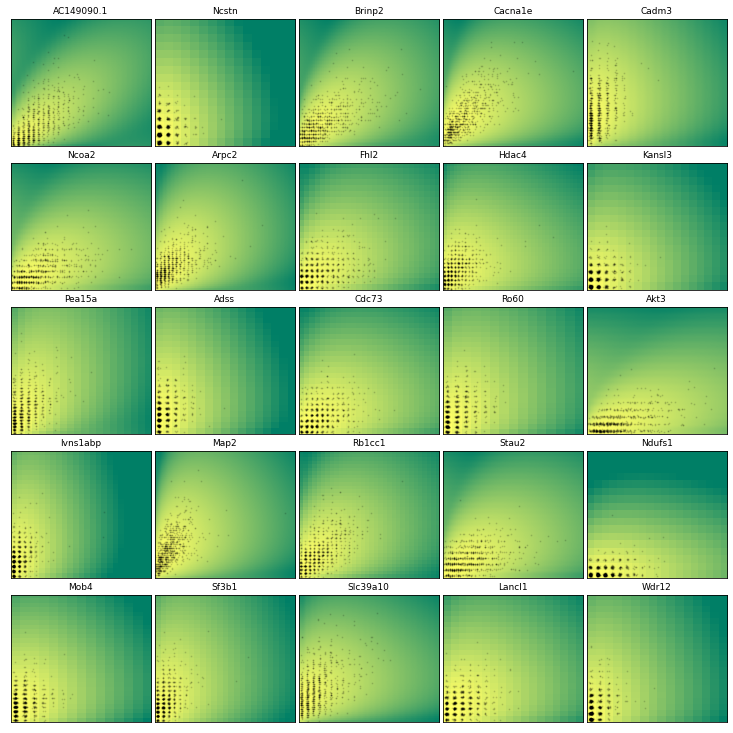

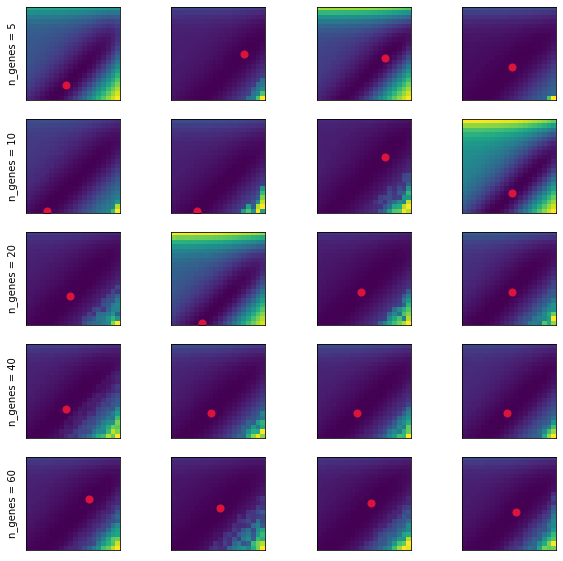

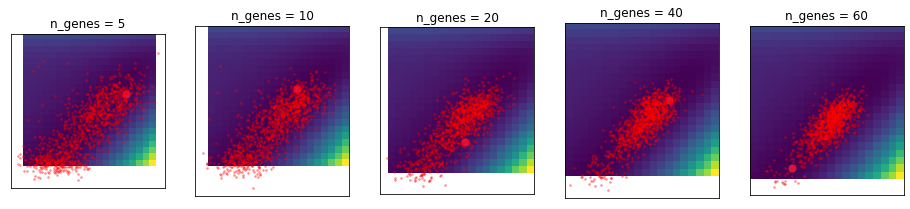

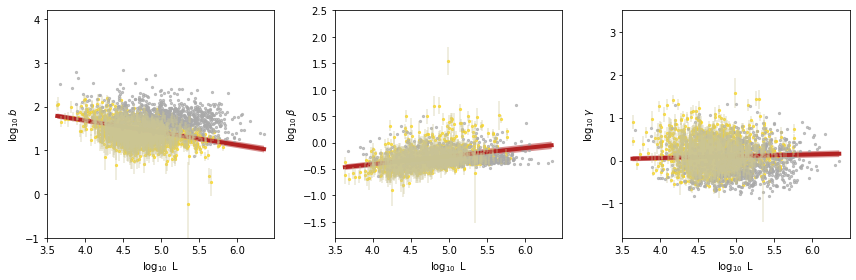

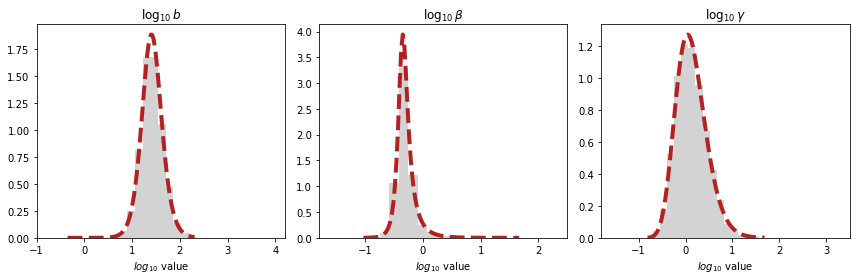

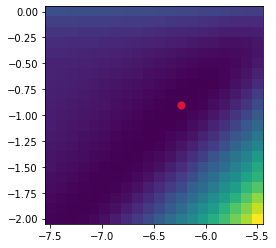

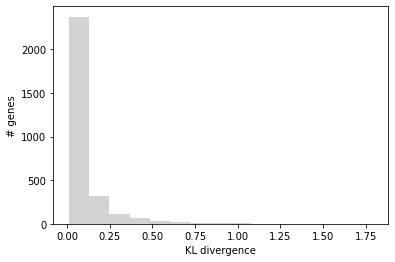

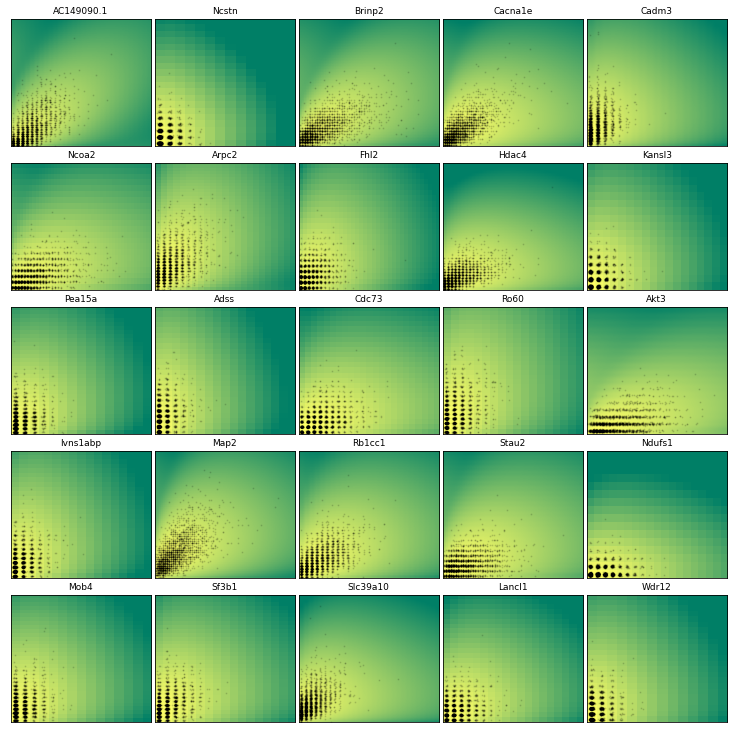

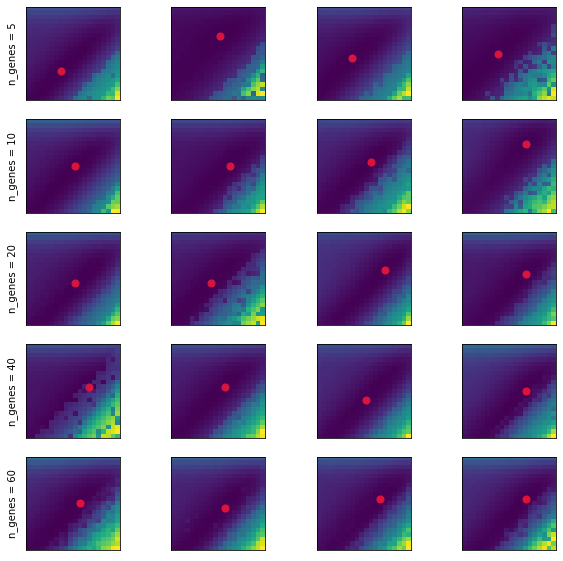

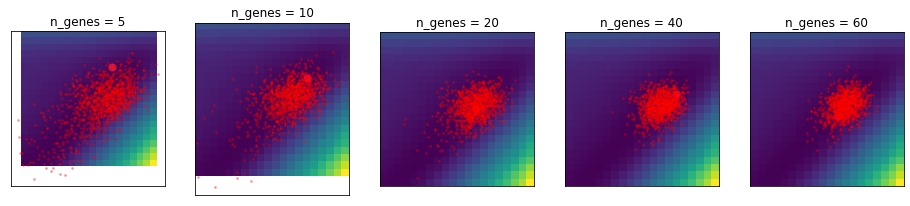

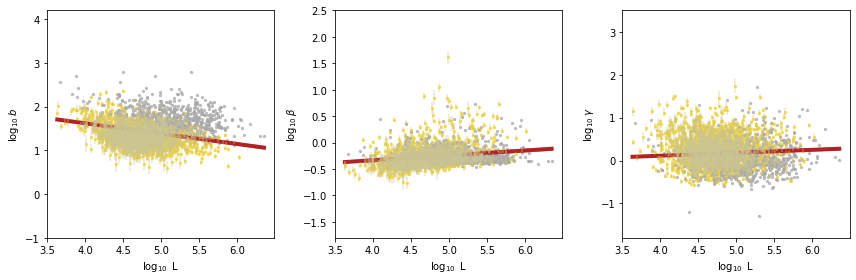

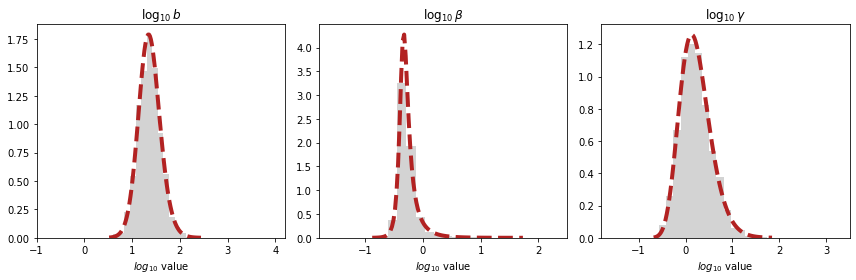

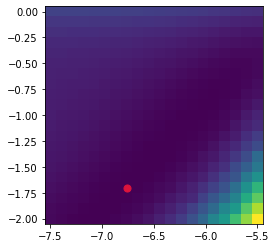

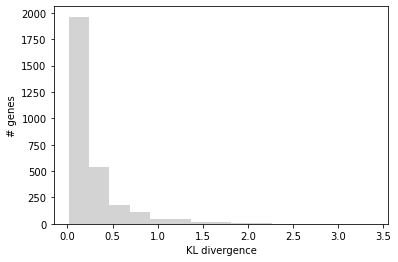

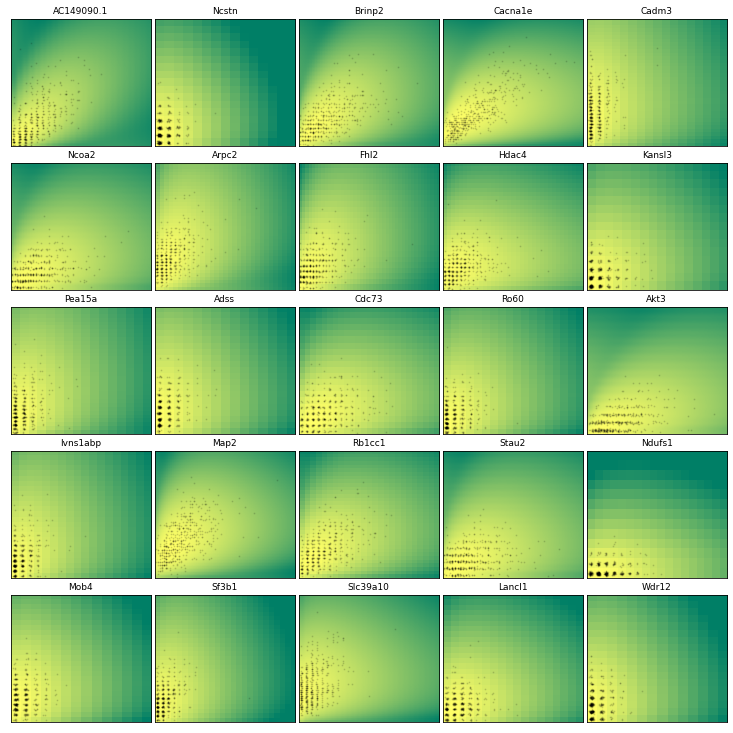

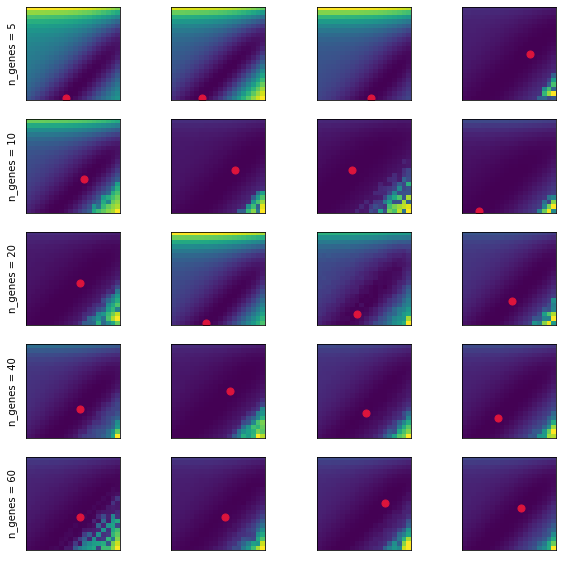

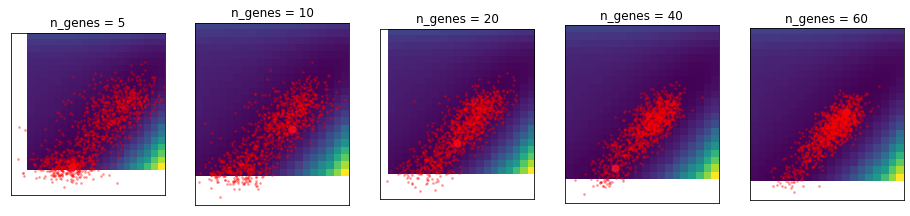

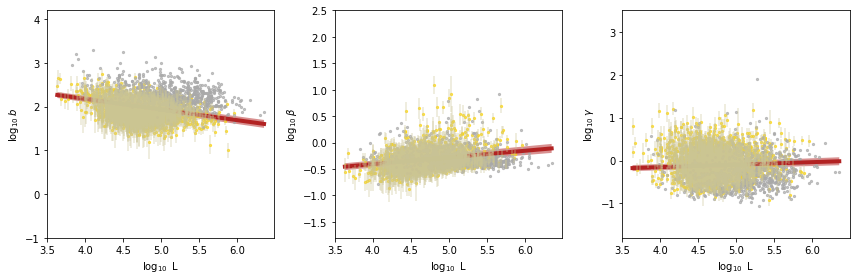

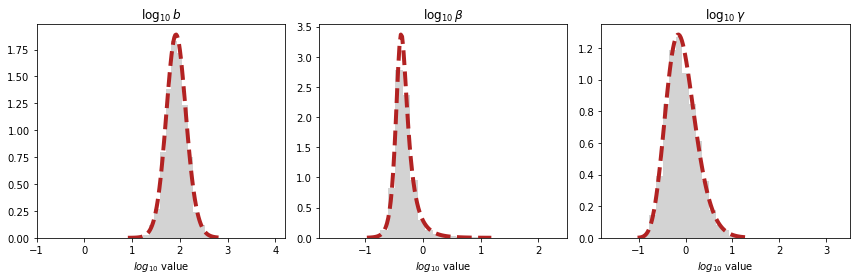

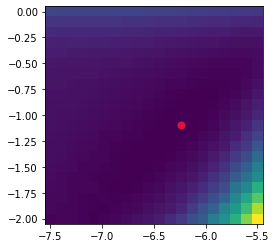

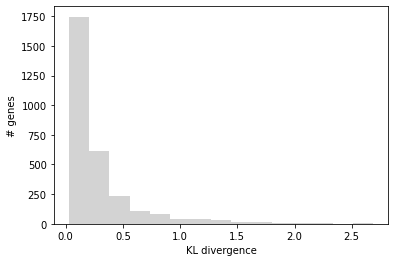

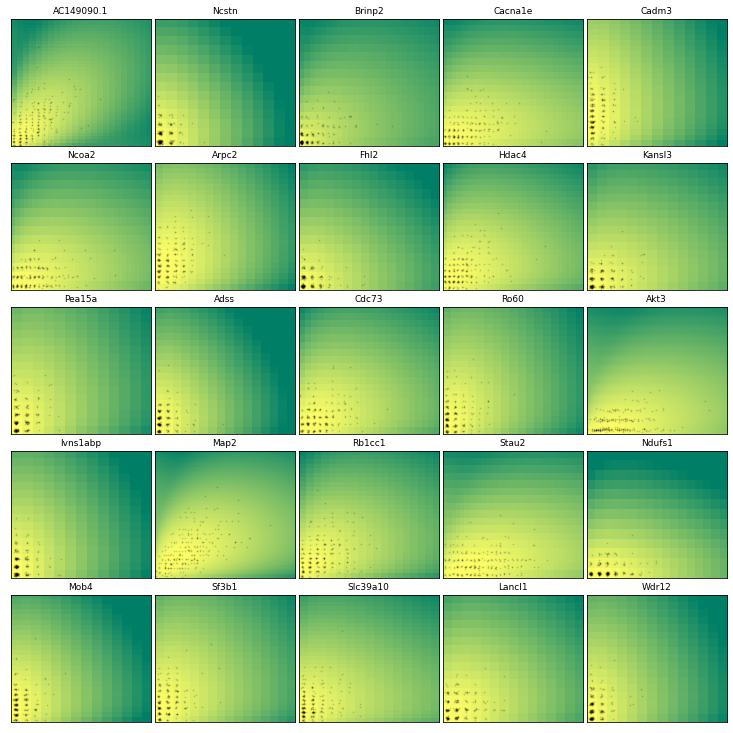

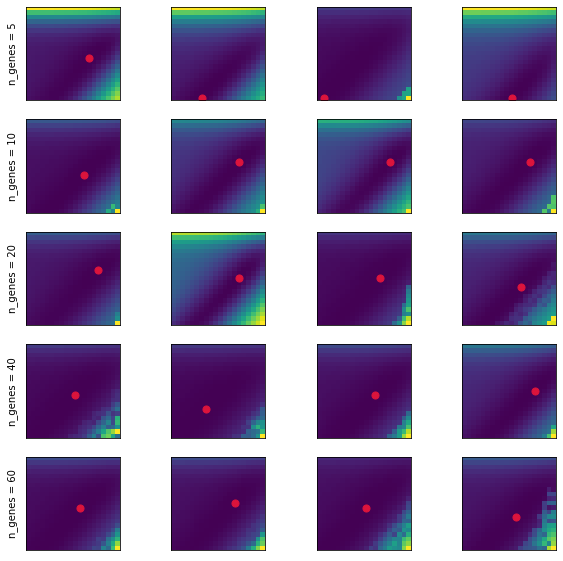

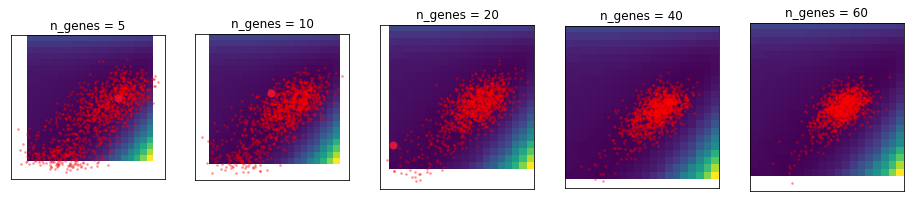

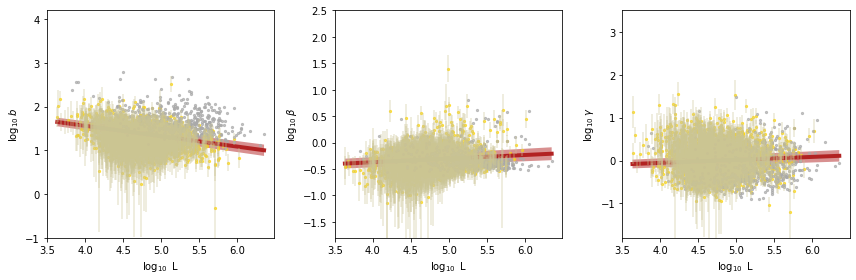

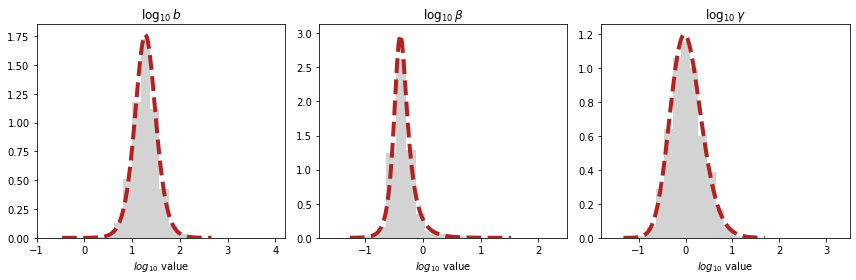

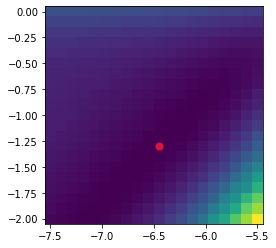

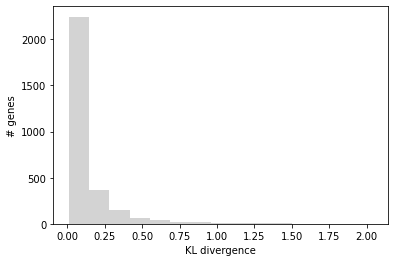

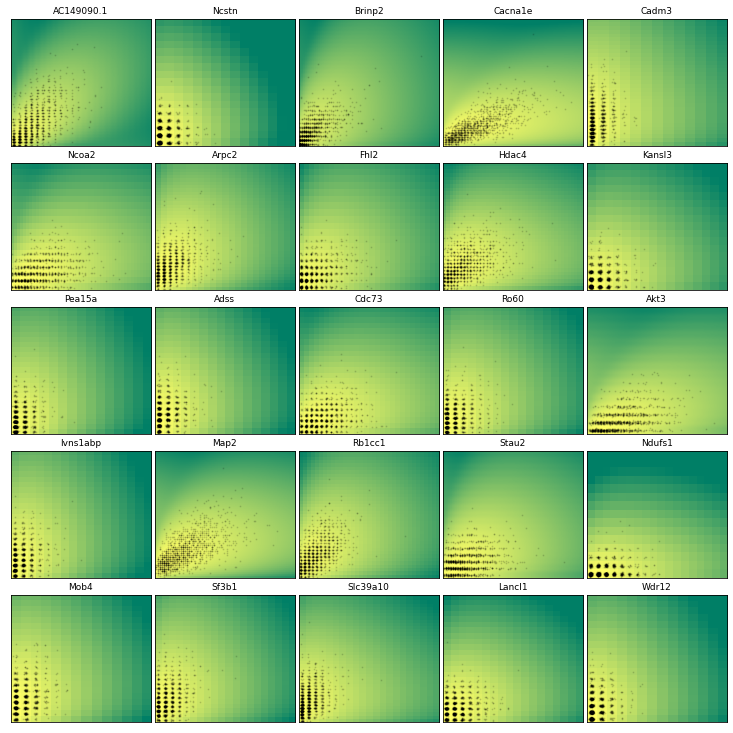

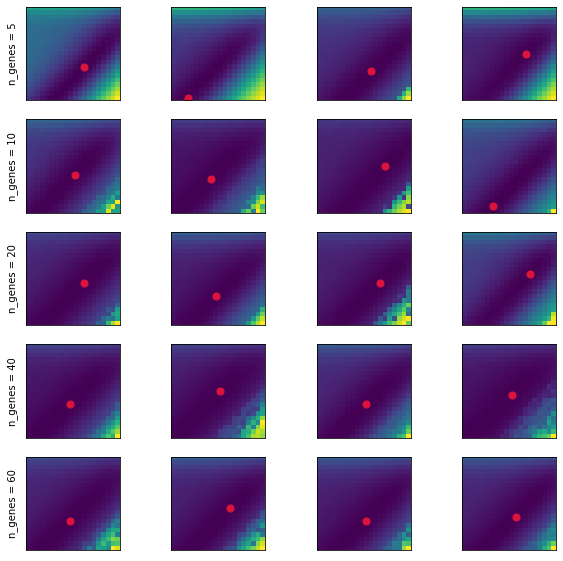

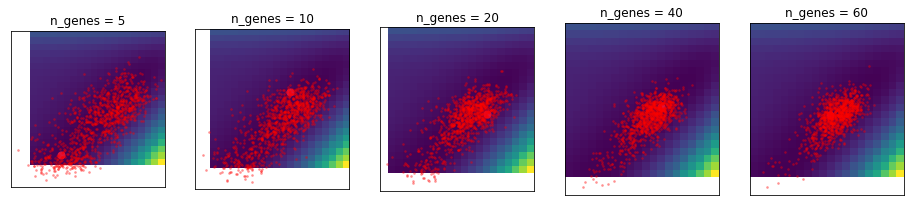

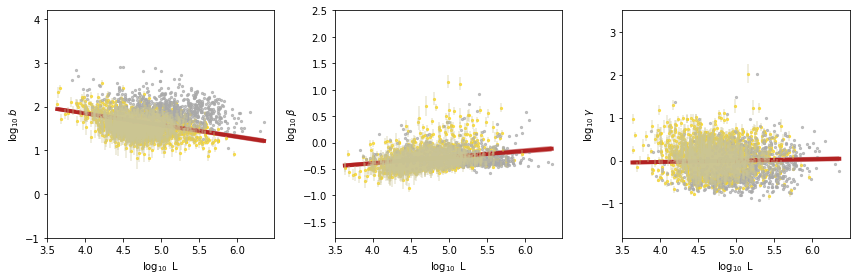

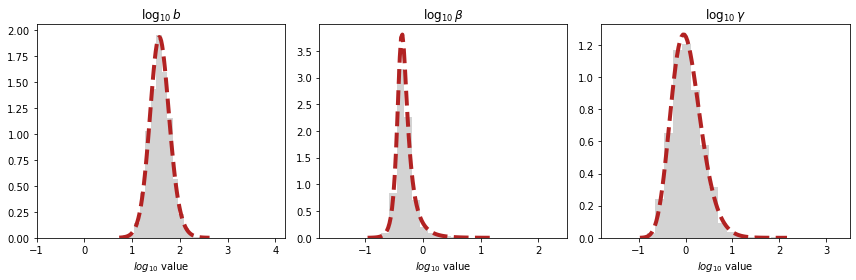

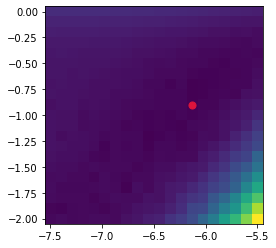

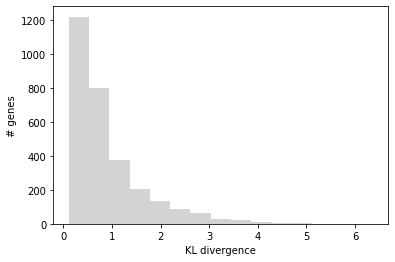

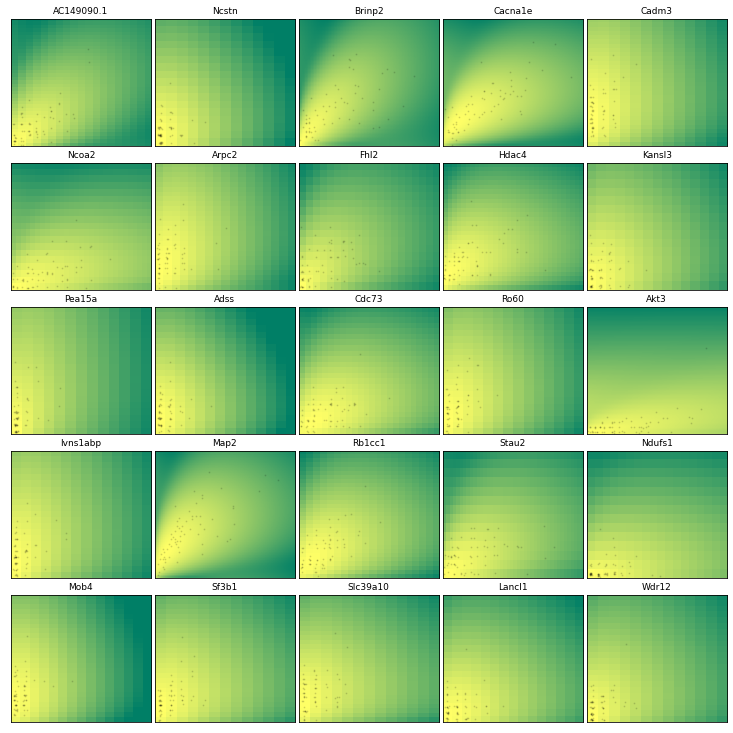

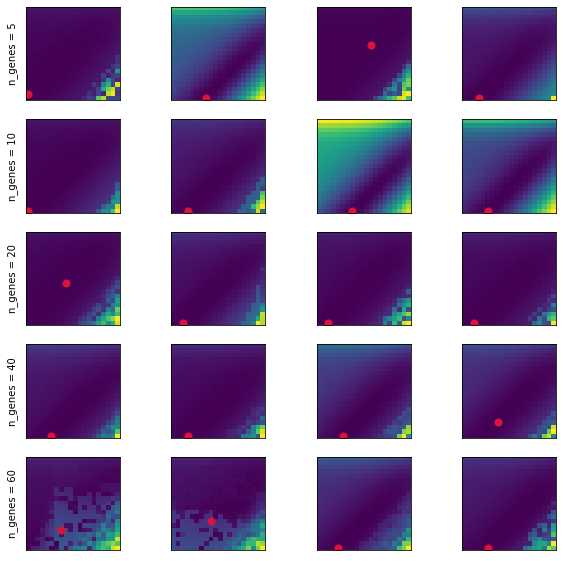

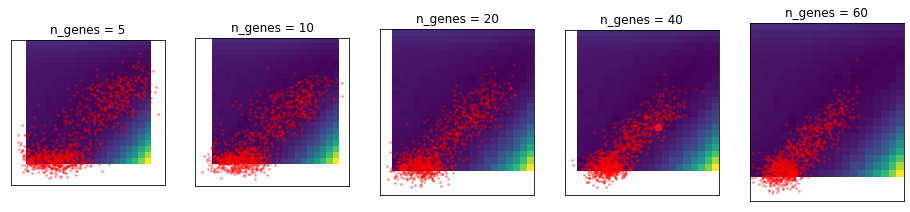

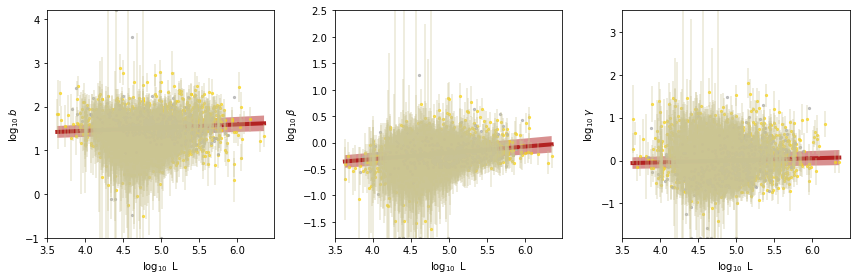

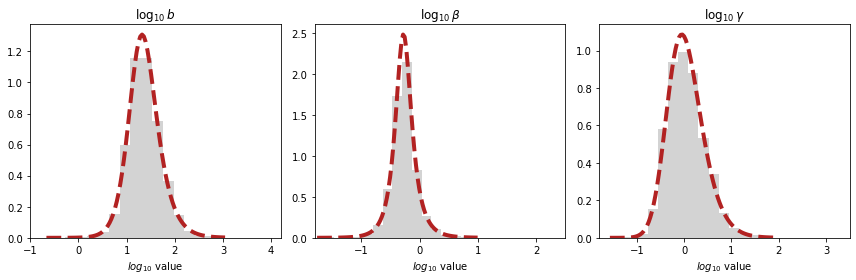

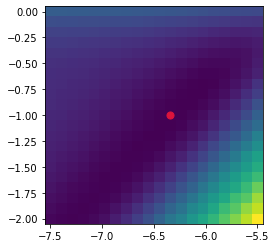

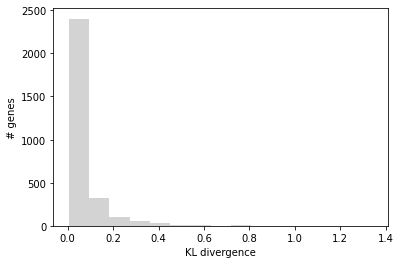

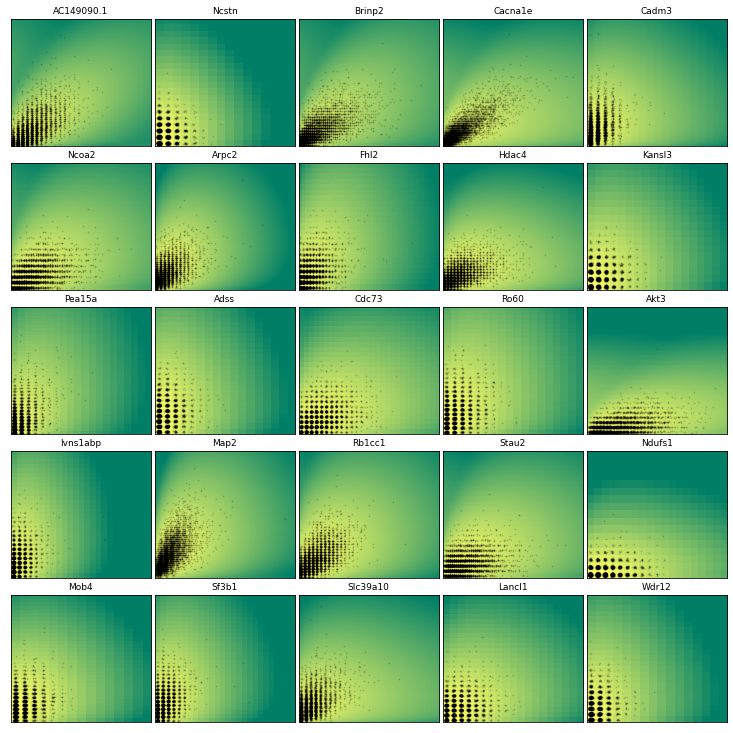

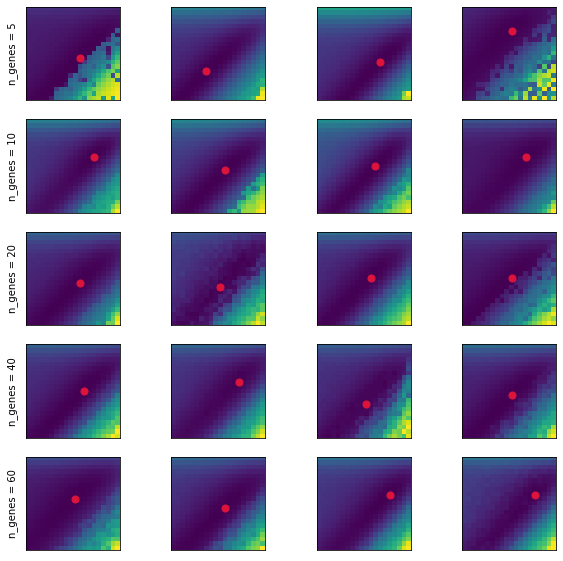

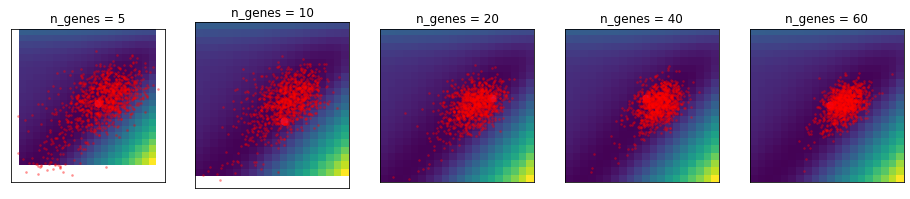

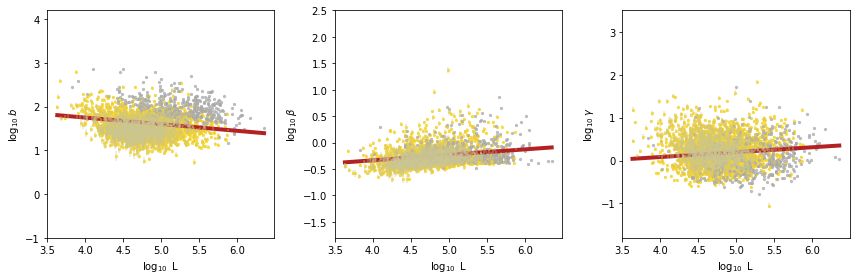

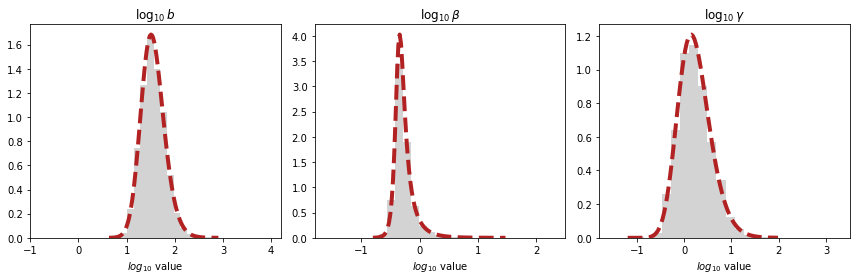

In [29]:
for i in range(n_datasets):
    sr = monod.analysis.load_search_results(result_strings[i])
    sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[i]+'/raw.sd')
    fig1,ax1 = plt.subplots(1,1)
    sr.find_sampling_optimum()
    sr.plot_landscape(ax1)

    fig1,ax1 = plt.subplots(1,1)
    sr.plot_KL(ax1)

    sr.plot_gene_distributions(sd,marg='joint')

    _=sr.chisquare_testing(sd,threshold=1e-3)
    sr.resample_opt_viz()
    sr.resample_opt_mc_viz()
    sr.chisq_best_param_correction(sd,Ntries=4,viz=False,threshold=1e-3) 

    sr.compute_sigma(sd,num_cores=60)
    sr.plot_param_L_dep(plot_errorbars=True,plot_fit=True)
    sr.plot_param_marg()
    
    monod.analysis.make_batch_analysis_dir([sr],dir_string)
    sr.update_on_disk()
    